In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.spatial.distance as dist

import sys

import time

import pandas as pd

from expected_min_dist import expected_dist_conf, gen_centers


In [2]:
def greedy_step(servers, request):
    # Find the smallest distance between the servers and the point
    min_idx = -1
    min_dist = float('inf')
    for i, server in enumerate(servers):
        request_dist = dist.euclidean(server, request)
        # Store if new min
        if request_dist < min_dist:
            min_dist = request_dist
            min_idx = i
    return min_idx, min_dist

def heuristic_step(servers, request, nu=1.):
    # Find the smallest distance between the servers and the point
    min_idx = -1
    min_dist = float('inf')
    min_loss = float('inf')
    for i, server in enumerate(servers):
        request_dist = dist.euclidean(server, request)
        # Suppose we move the server, this is the new config
        future_servers = servers[: i] + [request] + servers[i+1:]
        # Compute the future expected minimum distance
        exp_dist = expected_dist_conf(future_servers, draw=False)
        # This is the heuristic loss function
        loss = request_dist + nu*exp_dist
        # Store minimum
        if loss < min_loss:
            min_loss = loss
            min_dist = request_dist
            min_idx = i
    return min_idx, min_dist

In [3]:
# Run a kserver algorithm
def _run_kserver(alg_step, servers, requests, **kwargs):
    # Copy list
    cur_servers = list(servers)
    total_dist = 0.
    for request in requests:
        # Compute next step
        idx, min_dist = alg_step(cur_servers, request, **kwargs)
        total_dist += min_dist
        # Take the step
        cur_servers[idx] = request
    return total_dist


def greedy_kserver(servers, requests):
    return _run_kserver(greedy_step, servers=servers, requests=requests)

def heuristic_kserver(servers, requests, nu=1.):
    return _run_kserver(heuristic_step, servers=servers, requests=requests, nu=nu)



In [4]:
experiment1 = {
    'num_requests': 1000,
    'num_servers': 5,
    'num_reps': 5,
    'num_nus': 40
}

In [5]:
def run_mean_ratios_exp(num_requests, num_servers, num_reps, num_nus):
    nus = np.linspace(0, 10, num_nus)
    mean_ratios = {nu:0. for nu in nus}

    for i in xrange(num_reps):
        #print i
        #sys.stdout.flush()
        servers = gen_centers(num_servers)
        requests = gen_centers(num_requests)

        greedy_cost = greedy_kserver(servers, requests)

        for nu in nus:
            #print "\t", nu
            #sys.stdout.flush()
            mean_ratios[nu] += heuristic_kserver(servers, requests, nu=nu) \
                             / greedy_cost


    for k,v in mean_ratios.iteritems():
        mean_ratios[k] = v/num_reps
    
    
    return nus, mean_ratios

In [6]:
def display_mean_ratios(num_servers, nus, mean_ratios):
    save_path = "results/ratio_plots/"
    fig, ax = plt.subplots()

    ax.plot(nus, list(mean_ratios[nu] for nu in nus))

    ax.set_xlabel(r"$\eta$", fontsize=15)
    ax.set_ylabel("Cost Ratio", fontsize=15)
    ax.set_title("Ratio heuristic to greedy (k={})".format(num_servers))
    plt.savefig("{}mean_ratio_k{}.pdf".format(save_path, num_servers), 
                bbox_inches='tight')

k:  5
finished 2016-12-21 21:31:20

k:  6
finished 2016-12-21 21:38:57

k:  7
finished 2016-12-21 21:49:09

k:  8
finished 2016-12-21 22:02:22



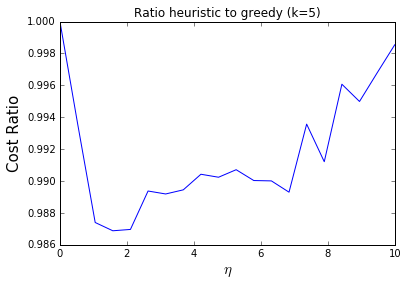

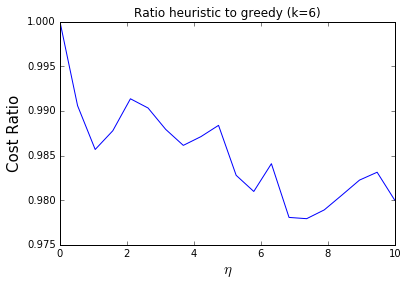

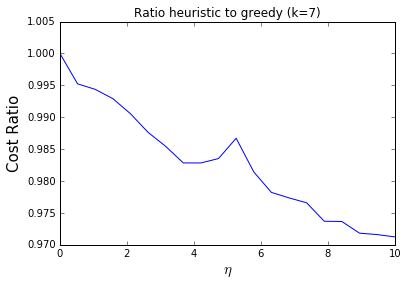

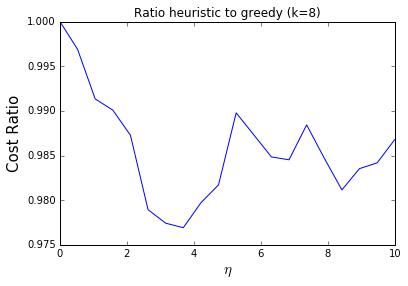

In [9]:
for k in xrange(5, 9):
    print "k: ", k
    experiment = {
    'num_requests': 300,
    'num_servers': k,
    'num_reps': 10,
    'num_nus': 20
    }
    nus, mean_ratios = run_mean_ratios_exp(**experiment)
    display_mean_ratios(experiment['num_servers'], nus, mean_ratios)
    print "finished", time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime())
    print ""

